## Pipeline with breast cancer data of cBioPortal to check link between high proliferation/ Invasion and low Apoptosis with worse survival outcome

In [67]:
import pandas as pd
import numpy as np
import os
import shutil
import maboss
import gseapy as gp
from functions.validation_utils.validation_Breast import (
    process_montagud_nodes,process_montagud_nodes_synonyms, process_genes, preprocess_cnv,create_generic_patients_cfgs_bnds, personalized_patients_genes_cfgs, generic_models_update_phenotypes, tailor_bnd_cnv_cm, correlate_boolean_predictions_with_gene_signatures
)


from functions.analysis_utils.MaBoSS_simulation.maboss_phenotype_patient import collect_group_data

### Loading the dataset

In [2]:
#  somatic mutations, copy number alterations, and gene expression
# 2509 models


genes_data = pd.read_csv('data/cBioPortal/data_mrna_illumina_microarray_zscores_ref_diploid_samples.txt', sep='\t')
mutations_data = pd.read_csv('data/cBioPortal/data_mutations.txt', sep='\t', skiprows=1)
cnv_data = pd.read_csv('data/cBioPortal/data_cna.txt', sep='\t')
clinical_patients_data = pd.read_csv('data/cBioPortal/data_clinical_patient.txt', sep='\t',skiprows=4)
clinical_samples = pd.read_csv('data/cBioPortal/data_clinical_sample.txt',sep='\t',skiprows=4)
nodes_montagud_synonyms = pd.read_csv('data/fumia_models/nodes_processed.txt',sep='\t')


montagud_original_data_df = (
    pd.read_csv('data/montagud_models/Montagud_inter_nodes_data.csv', header=1)
    .loc[:, ['Target node', 'Interaction type', 'Source']])



In [3]:
folder = 'validation_Breast'
folder_generic_models = f"analysis/{folder}/models/generic/"
folder_models = f"analysis/{folder}/models"

if not os.path.exists(f"analysis/{folder}/results"):
    os.makedirs(f"analysis/{folder}/results")

if not os.path.exists(f"analysis/{folder}/models/personalized"):
    os.makedirs(f"analysis/{folder}/models/personalized")

dest_dir = f"analysis/{folder}/models/generic"
os.makedirs(dest_dir, exist_ok=True)



shutil.copy('data/fumia_models/Fumia2013.bnd', dest_dir)
shutil.copy('data/fumia_models/Fumia2013.cfg', dest_dir) 

'analysis/validation_Breast/models/generic/Fumia2013.cfg'

Get patients IDs (Try random group of patients)

In [4]:

nb_patients = 100

patients_ids_clinical = list(set(clinical_patients_data['PATIENT_ID']))
patients_ids_mutations = list(set(mutations_data['Tumor_Sample_Barcode']))
patients_ids_genes = list(set(genes_data.columns[2:]))
patients_ids_cnv = list(set(cnv_data.columns[2:]))

common_patients = list(set(patients_ids_clinical) & set(patients_ids_mutations) & set(patients_ids_genes) & set(patients_ids_cnv))
patients_ids = [patient for patient in common_patients if patient.startswith('MB')][:nb_patients]

Filtering/ Preprocessing datasets

In [5]:
# Keep Hugo_Symbol, Entrez_Gene_Id, and patient columns
cnv_data_filtered = cnv_data[['Hugo_Symbol', 'Entrez_Gene_Id'] + 
                             [col for col in cnv_data.columns if col in patients_ids]]
genes_data_filtered = genes_data[['Hugo_Symbol', 'Entrez_Gene_Id'] + 
                             [col for col in genes_data.columns if col in patients_ids]]

genes_data_filtered = genes_data[['Hugo_Symbol', 'Entrez_Gene_Id'] + 
                             [col for col in genes_data.columns if col in patients_ids]]
mutations_data_filtered = mutations_data[mutations_data['Tumor_Sample_Barcode'].isin(patients_ids)]

clinical_patients_data_filtered = clinical_patients_data[clinical_patients_data['PATIENT_ID'].isin(patients_ids)]

In [6]:
# Phenotypes
phenotype_interest = ["Proliferation","Apoptosis"]



In [7]:
montagud_node_synonyms, synonyms_to_nodes_dict = process_montagud_nodes_synonyms(nodes_montagud_synonyms)
montagud_node_model, all_montagud_nodes = process_montagud_nodes(
    montagud_original_data_df, montagud_node_synonyms)

In [8]:
rna_seq_data_final = process_genes(patients_ids, genes_data_filtered, all_montagud_nodes, synonyms_to_nodes_dict)

 Duplicated MTOR: mTORC1 (1 rows) + mTORC2 (1 rows)
 Duplicated MYC: MYC (1 rows) + MYC_MAX (1 rows)
 Duplicated PIK3CA: PI3K (1 rows) + PIP3 (1 rows)
 Duplicated LDHA: LDHA (1 rows) + Lactic_acid (1 rows)
 Duplicated ERG: AR_ERG (1 rows) + ERG (1 rows)


/Users/romane/repos/icr/Attractor-Resistance/functions/validation_utils/validation_Breast.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_seq_data_filtered['Hugo_Symbol'] = rna_seq_data_filtered['Hugo_Symbol'].str.strip()


In [9]:
cnv_data_filt = preprocess_cnv(patients_ids, cnv_data, all_montagud_nodes, synonyms_to_nodes_dict)

## Create personalized boolean networks (genes and CNV)

In [10]:
folder_models = 'analysis/validation_Breast/models/personalized'


In [11]:
create_generic_patients_cfgs_bnds(
    folder_generic_models,
    folder_models,
    patients_ids,
)

All .cfg and .bnd files created for sensitive, resistant and healthy patients.


In [12]:
generic_models_update_phenotypes(phenotype_interest, folder_models)

Updated Proliferation.is_internal=FALSE in MB-7020.cfg
Updated Apoptosis.is_internal=FALSE in MB-7020.cfg
Modified and saved: analysis/validation_Breast/models/personalized/MB-7020.cfg
Updated Proliferation.is_internal=FALSE in MB-5623.cfg
Updated Apoptosis.is_internal=FALSE in MB-5623.cfg
Modified and saved: analysis/validation_Breast/models/personalized/MB-5623.cfg
Updated Proliferation.is_internal=FALSE in MB-4887.cfg
Updated Apoptosis.is_internal=FALSE in MB-4887.cfg
Modified and saved: analysis/validation_Breast/models/personalized/MB-4887.cfg
Updated Proliferation.is_internal=FALSE in MB-0439.cfg
Updated Apoptosis.is_internal=FALSE in MB-0439.cfg
Modified and saved: analysis/validation_Breast/models/personalized/MB-0439.cfg
Updated Proliferation.is_internal=FALSE in MB-5233.cfg
Updated Apoptosis.is_internal=FALSE in MB-5233.cfg
Modified and saved: analysis/validation_Breast/models/personalized/MB-5233.cfg
Updated Proliferation.is_internal=FALSE in MB-0175.cfg
Updated Apoptosis.is

In [13]:
personalized_patients_genes_cfgs(
    rna_seq_data_final,
    all_montagud_nodes,
    folder_models,
    amplif_factor = 100,
)

Applying min-max normalization per gene...
Normalization completed!
Original column: 'rsem_tpm', Normalized column: 'rsem_tpm_normalized'
==== Processing all genes per patient ===

Processing file: MB-7020.cfg
  No data for INSR
  No data for PRKCA
  No data for ERBB3
  No data for CCND1
  No data for AKT1
  No data for E2F1
  No data for RAG1
  No data for COX4I2
  No data for GSK3A
  No data for RB1
  No data for BAK1
  No data for FLT3
  No data for CASP9
  No data for TSC2
  No data for RPS6KA1
  No data for E2F2
  No data for ANAPC1
  No data for HIF1A
  No data for BCL2L1
  No data for MAPK8
  No data for CDKN1A
  No data for ARAF
  No data for E2F6
  No data for CHUK
  No data for CCNA2
  No data for CDC20
  No data for RAF1
  No data for SNAI2
  No data for CCND3
  No data for GSS
  No data for PTK7
  No data for EEF2K
  No data for nan
  No data for VEGFC
  No data for TP53
  No data for MAPK1
  No data for VEGFD
  No data for RPS6KB1
  No data for CDKN2A
  No data for TCF7L1


In [14]:
tailor_bnd_cnv_cm(cnv_data_filt, folder_models)

🔍 Processing patient MB-4293, gene: AXIN1
No AXIN1 node found in file for patient MB-4293
🔍 Processing patient MB-4293, gene: eEF2K
eEF2K node found. Replacing...
🔍 Processing patient MB-4293, gene: RTK
RTK node found. Replacing...
🔍 Processing patient MB-4293, gene: TSC1_2
TSC1_2 node found. Replacing...
MB-4293: CNV — nodes modified
🔍 Processing patient MB-6256, gene: RTK
RTK node found. Replacing...
MB-6256: CNV — nodes modified
🔍 Processing patient MB-0175, gene: E2F
E2F node found. Replacing...
🔍 Processing patient MB-0175, gene: FRS2
No FRS2 node found in file for patient MB-0175
🔍 Processing patient MB-0175, gene: Mdm2
Mdm2 node found. Replacing...
🔍 Processing patient MB-0175, gene: PKC
PKC node found. Replacing...
🔍 Processing patient MB-0175, gene: p70S6kab
p70S6kab node found. Replacing...
🔍 Processing patient MB-0175, gene: SPOP
No SPOP node found in file for patient MB-0175
MB-0175: CNV — nodes modified
🔍 Processing patient MB-5483, gene: CyclinE
CyclinE node found. Replac

## MaBoSS simulation

In [15]:


# loop over max time to identify the one for which the algo converges
def compute_phenotype_table(
    folder_save_results,
    folder_models,
    patient_id,
    input_nodes,
    phenotypes_interest,
):


    model_pers_bnd = f"{folder_models}/{patient_id}.bnd"
    model_pers_cfg = f"{folder_models}/{patient_id}.cfg"

    if not os.path.exists(model_pers_bnd) or not os.path.exists(model_pers_cfg):
        print(f"Missing model files for {patient_id}")
        return None

    model_pers_lung = maboss.load(model_pers_bnd, model_pers_cfg)

    results = pd.DataFrame(index=input_nodes, columns=phenotypes_interest)

    threshold_diff = 0.01
    initial_max_time = 5
    max_time_limit = 30

    for active_node in input_nodes:
        model_pers_lung.network.set_istate(active_node, [0, 1])
        for inactive_node in input_nodes:
            if inactive_node != active_node:
                model_pers_lung.network.set_istate(inactive_node, [1, 0])

        converged = False
        current_max_time = initial_max_time
        while not converged and current_max_time < max_time_limit:
            model_pers_lung.update_parameters(
                time_tick=0.1, max_time=current_max_time, sample_count=500
            )
            res_lung_pers = model_pers_lung.run()

            last_state = res_lung_pers.get_nodes_probtraj()
            if len(last_state) < 10:
                print(
                    f"[{active_node}] Warning: Not enough data for convergence check."
                )
                break
            diff = last_state.diff().abs()
            max_change_recent = diff.tail(10).max()
            # print(f"Max change over last 10 time steps for {active_node}:\n{max_change_recent}\n")
            if (max_change_recent > threshold_diff).any():
                current_max_time += 1
            else:
                converged = True
        if not converged:
            print(
                f"[{active_node}] Did not fully converge by max_time = {max_time_limit}."
            )
        final_probs = last_state.iloc[-1]
        # print(f"[{active_node}] Final probabilities:\n{final_probs}\n")
        for phenotype in phenotypes_interest:
            if phenotype in final_probs.index:
                results.loc[active_node, phenotype] = final_probs[phenotype]
    results.to_csv(f"{folder_save_results}/{patient_id}.csv")
    return results

In [16]:
folder_save_results = 'analysis/validation_Breast/results'
inputs_list = ['GLI', 'MAX', 'PTEN', 'Acidosis', 'p14ARF', 'ROS', 'Hypoxia', 'Nutrients', 'Carcinogen', 'GFs', 'TNFalpha']


In [17]:
for patient in patients_ids:
    results_maboss = compute_phenotype_table(
        folder_save_results,
        folder_models,
        patient,
        inputs_list,
        phenotype_interest,
    )

In [18]:
group_folder_path = 'analysis/validation_Breast/results'


In [19]:
import pandas as pd
import os
from pathlib import Path

def combine_patient_results(results_folder):
    """
    Combine individual patient CSV files into one dataframe
    """
    all_data = []
    
    # Get all CSV files in the results folder
    csv_files = [f for f in os.listdir(results_folder) if f.endswith('.csv')]
    
    for csv_file in csv_files:
        # Extract patient ID from filename (remove .csv extension)
        patient_id = Path(csv_file).stem
        
        # Read the CSV file
        df = pd.read_csv(os.path.join(results_folder, csv_file), index_col=0)
        
        # Calculate mean values across all inputs for each phenotype
        patient_data = {
            'patient_id': patient_id,
            'Proliferation': df['Proliferation'].mean(),
            'Apoptosis': df['Apoptosis'].mean()
        }
        
        all_data.append(patient_data)
    
    # Create combined dataframe
    combined_df = pd.DataFrame(all_data)
    combined_df.set_index('patient_id', inplace=True)
    
    return combined_df

# Use the function
results_folder = 'analysis/validation_Breast/results'
combined_results = combine_patient_results(results_folder)

In [20]:
# Create groups based on proliferation level and then apoptosis level
combined_results_survival = combined_results.copy()
combined_results_survival['Group_Proliferation'] = np.where(
    combined_results_survival['Proliferation'] < combined_results['Proliferation'].mean(), 
    'low', 
    'high'
)

# You can also create groups for Apoptosis
combined_results_survival['Group_Apoptosis'] = np.where(
    combined_results_survival['Apoptosis'] < combined_results['Apoptosis'].mean(), 
    'low', 
    'high'
)

## Survival analysis


In [21]:
survival_columns = [
    'PATIENT_ID',           # Patient identifier
    'OS_MONTHS',            # Overall survival time (months)
    'OS_STATUS',            # Overall survival status (0=alive, 1=dead)
]

clinical_patients_data_filtered = clinical_patients_data_filtered[survival_columns]

In [22]:
clinical_patients_ids = list(set(clinical_patients_data_filtered['PATIENT_ID']))

In [23]:
combined_results = combined_results.reset_index()
patients_ids_phenotype_data = list(set(combined_results['patient_id']))

In [ ]:
# merge the two 
# Same as above but using the dataframe method
survival_analysis_data = clinical_patients_data_filtered.merge(
    combined_results, 
    left_on='PATIENT_ID', 
    right_on='patient_id', 
    how='inner'
)



survival_analysis_data['OS_STATUS'] = survival_analysis_data['OS_STATUS'].map({
        '0:LIVING': 0,
        '1:DECEASED': 1,
        'LIVING': 0,
        'DECEASED': 1,
        0: 0,
        1: 1
    })

In [33]:
survival_analysis_data

,PATIENT_ID,OS_MONTHS,OS_STATUS,patient_id,Proliferation,Apoptosis
0,MB-0097,98.700000,0,MB-0097,0.055271,0.250959
1,MB-0122,138.900000,0,MB-0122,0.036281,0.311684
2,MB-0138,150.566667,0,MB-0138,0.096368,0.454837
3,MB-0149,51.700000,1,MB-0149,0.994800,0.903669
4,MB-0162,55.766667,0,MB-0162,0.055504,0.248867
...,...,...,...,...,...,...
95,MB-7238,23.266667,1,MB-7238,0.172115,0.275539
96,MB-7263,164.966667,1,MB-7263,0.996368,0.384302
97,MB-7266,68.166667,1,MB-7266,0.111956,0.689502
98,MB-7269,21.166667,1,MB-7269,0.992077,0.096175


In [34]:
survival_analysis_data


survival_analysis_data['Group_Proliferation'] = np.where(
    survival_analysis_data['Proliferation'] < survival_analysis_data['Proliferation'].median(), 
    'low', 
    'high'
)

# You can also create groups for Apoptosis using median
survival_analysis_data['Group_Apoptosis'] = np.where(
    survival_analysis_data['Apoptosis'] < survival_analysis_data['Apoptosis'].median(), 
    'low', 
    'high'
)

In [35]:
survival_analysis_data

,PATIENT_ID,OS_MONTHS,OS_STATUS,patient_id,Proliferation,Apoptosis,Group_Proliferation,Group_Apoptosis
0,MB-0097,98.700000,0,MB-0097,0.055271,0.250959,low,low
1,MB-0122,138.900000,0,MB-0122,0.036281,0.311684,low,low
2,MB-0138,150.566667,0,MB-0138,0.096368,0.454837,low,low
3,MB-0149,51.700000,1,MB-0149,0.994800,0.903669,high,high
4,MB-0162,55.766667,0,MB-0162,0.055504,0.248867,low,low
...,...,...,...,...,...,...,...,...
95,MB-7238,23.266667,1,MB-7238,0.172115,0.275539,low,low
96,MB-7263,164.966667,1,MB-7263,0.996368,0.384302,high,low
97,MB-7266,68.166667,1,MB-7266,0.111956,0.689502,low,high
98,MB-7269,21.166667,1,MB-7269,0.992077,0.096175,high,low


Group 'low': 50 patients
Group 'high': 50 patients

Log-rank test:
Test statistic: 0.5812
p-value: 0.4458
Significant difference (α=0.05): False

Plot saved to: analysis/validation_Breast/results/outputs/cnv_discrete_genes_continuous/survival_analysis_group-proliferation.png


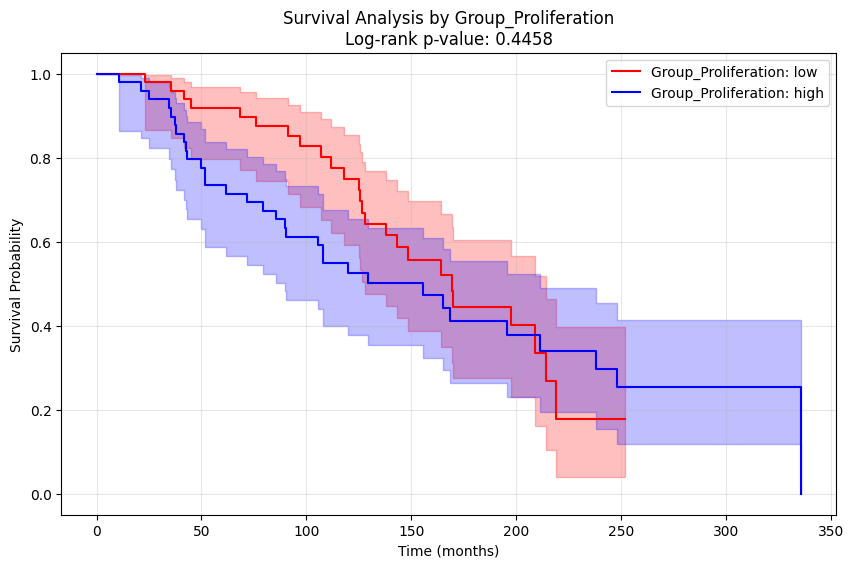

Group 'low': 50 patients
Group 'high': 50 patients

Log-rank test:
Test statistic: 1.5270
p-value: 0.2166
Significant difference (α=0.05): False

Plot saved to: analysis/validation_Breast/results/outputs/cnv_discrete_genes_continuous/survival_analysis_group-apoptosis.png


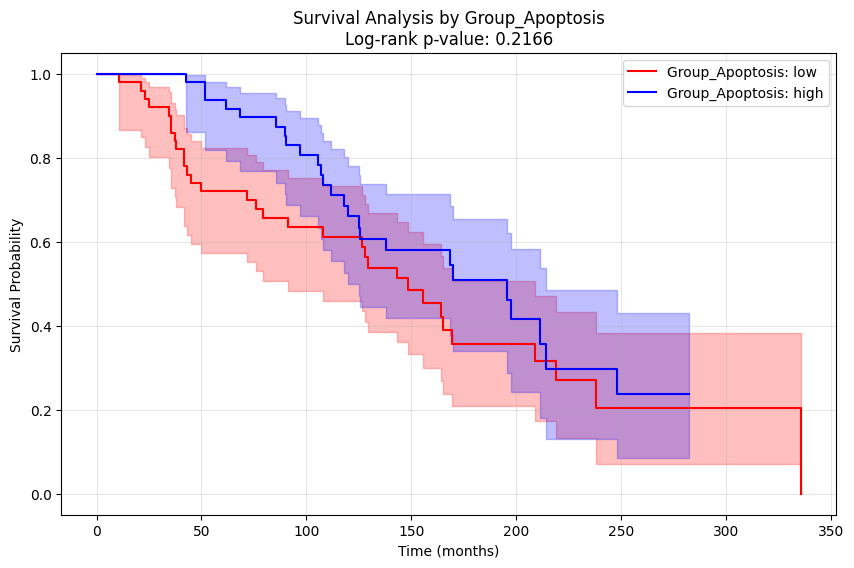

In [36]:
def survival_analysis_comparison(data, group_col, time_col='OS_MONTHS', event_col='OS_STATUS', pers_technique=None, save_plots=True):
    """
    Perform complete survival analysis comparison between groups
    """
    from lifelines.statistics import logrank_test
    from lifelines import KaplanMeierFitter
    import matplotlib.pyplot as plt
    import os
    
    # Get unique groups
    groups = data[group_col].unique()
    
    if len(groups) != 2:
        print(f"Warning: Expected 2 groups, found {len(groups)}")
        return None
    
    # Separate groups
    group1_data = data[data[group_col] == groups[0]]
    group2_data = data[data[group_col] == groups[1]]
    
    print(f"Group '{groups[0]}': {len(group1_data)} patients")
    print(f"Group '{groups[1]}': {len(group2_data)} patients")
    
    # Log-rank test
    results = logrank_test(
        group1_data[time_col], 
        group2_data[time_col],
        group1_data[event_col], 
        group2_data[event_col]
    )
    
    print(f"\nLog-rank test:")
    print(f"Test statistic: {results.test_statistic:.4f}")
    print(f"p-value: {results.p_value:.4f}")
    print(f"Significant difference (α=0.05): {results.p_value < 0.05}")
    
    # Plot Kaplan-Meier curves
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10, 6))
    
    # Plot each group
    colors = ['red', 'blue']
    for i, group in enumerate(groups):
        group_data = data[data[group_col] == group]
        kmf.fit(group_data[time_col], group_data[event_col], label=f'{group_col}: {group}')
        kmf.plot_survival_function(color=colors[i])
    
    plt.title(f'Survival Analysis by {group_col}\nLog-rank p-value: {results.p_value:.4f}')
    plt.xlabel('Time (months)')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save plot if requested
    if save_plots:
        # Create output directory
        if pers_technique:
            output_dir = f"analysis/validation_Breast/results/outputs/{pers_technique}"
        else:
            output_dir = "analysis/validation_Breast/results/outputs"
        
        os.makedirs(output_dir, exist_ok=True)
        
        # Create filename
        filename = f"survival_analysis_{group_col.lower().replace('_', '-')}.png"
        filepath = os.path.join(output_dir, filename)
        
        # Save the plot
        plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"\nPlot saved to: {filepath}")
    
    plt.show()
    
    return results

# Use the updated function
results = survival_analysis_comparison(
    survival_analysis_data, 
    'Group_Proliferation', 
    pers_technique='cnv_discrete_genes_continuous',
    save_plots=True
)

results = survival_analysis_comparison(
    survival_analysis_data, 
    'Group_Apoptosis',
    pers_technique='cnv_discrete_genes_continuous',
    save_plots=True
)

try to include mutations data

## Gene signature correlation

In [42]:
combined_results_for_corr = combined_results.copy()
combined_results_for_corr

,patient_id,Proliferation,Apoptosis
0,MB-0368,0.370230,0.989944
1,MB-4293,0.078533,0.504513
2,MB-7003,0.148854,0.235409
3,MB-7229,0.048711,0.771009
4,MB-5402,0.983850,0.087391
...,...,...,...
95,MB-5427,0.990136,0.241655
96,MB-5396,0.994918,0.525671
97,MB-3452,0.985215,0.724168
98,MB-7152,0.996482,0.866311


In [44]:
# Reset index to make patient_id a column if it's currently the index
combined_results_for_corr = combined_results.copy()
combined_results_for_corr = combined_results_for_corr.set_index('patient_id')
combined_results_for_corr


,Proliferation,Apoptosis
patient_id,,
MB-0368,0.370230,0.989944
MB-4293,0.078533,0.504513
MB-7003,0.148854,0.235409
MB-7229,0.048711,0.771009
MB-5402,0.983850,0.087391
...,...,...
MB-5427,0.990136,0.241655
MB-5396,0.994918,0.525671
MB-3452,0.985215,0.724168


In [46]:
genes_data

Hugo_Symbol  Entrez_Gene_Id  MB-0362  MB-0346  MB-0386  MB-0574  \
0            RERE             473  -0.7139   1.2266  -0.0053  -0.4399   
1          RNF165          494470  -0.4606   0.3564  -0.6800  -1.0563   
2            PHF7           51533  -0.3325  -1.0617   0.2587  -0.2982   
3           CIDEA            1149  -0.0129  -1.0394   3.2991  -0.2632   
4           TENT2          167153  -0.7853   0.0337  -0.6649   2.1640   
...           ...             ...      ...      ...      ...      ...   
20598       VPS72            6944  -0.2908   0.3443   0.4818   0.2503   
20599       CSMD3          114788  -0.5286  -0.4379   6.9258   1.0466   
20600      CC2D1A           54862   0.0068  -0.7520   0.0519   0.2502   
20601       IGSF9           57549   0.4053   1.2968   0.7962  -0.1634   
20602      FAM71A          149647  -1.1278   0.0321   0.6608  -0.3571   

       MB-0185  MB-0503  MB-0641  MB-0201  MB-0218  MB-0316  MB-0189  MB-0891  \
0      -0.5958   0.4729   0.4974  -1.1900  -0.9265  -0.2864  -0.2255   0.0352   
1      -0.0377  -0.6829  -0.2854  -0.4336  -0.0496  -0.8630   0.0542  -0.4364   
2      -1.2422   0.0558  -0.5011  -0.6418  -0.0694  -0.1360  -1.2587  -0.2808   
3      -1.0949   1.2628   2.0796  -0.8310  -0.6602  -0.8047   0.6999   2.5630   
4      -0.2031   1.0304   0.6046  -1.7557   0.3588  -1.0726   0.3028   0.3275   
...        ...      ...      ...      ...      ...      ...      ...      ...   
20598  -0.1057  -0.1657  -0.4730   1.4719  -0.5683   1.2389  -0.3177   0.4137   
20599  -0.1060   0.3284   0.0993  -0.1987  -0.6742  -0.3844  -0.3779   0.1029   
20600  -0.3376  -0.4705  -0.6036  -1.1946   0.5151   0.9165  -0.3033  -0.7961   
20601  -0.2418  -0.2545  -0.9814   1.9240  -0.6869   0.1766   0.1853   0.5657   
20602  -1.0923  -1.2238  -0.9668  -1.3778   0.8013  -1.0716   1.1919   0.9132   

       MB-0658  MB-0899  MB-0605  MB-0258  MB-0506  MB-0420  MB-0223  MB-0445  \
0      -1.4768  -0.7800  -0.9143   0.2175  -0.9681  -1.1354   0.8629  -0.2074   
1       0.4060   0.7863  -0.4828  -0.2302  -1.2051  -0.7091  -0.2893  -1.0955   
2      -0.8817  -0.1854   0.2704   0.6549  -1.2704  -1.7623  -0.2133  -0.1882   
3       0.6820   0.4412   1.6435   1.5936  -1.0720  -0.8469  -0.4784  -1.0150   
4      -0.1701  -0.9356  -0.3489   0.1245  -2.1237  -0.8710   0.8052   1.6761   
...        ...      ...      ...      ...      ...      ...      ...      ...   
20598   2.4002   0.2114   0.1239  -0.2757   1.7738  -0.1939  -0.4587  -1.2728   
20599   0.1807  -0.4446  -1.0359   0.4941  -0.1619  -0.4393   3.0723  -0.2403   
20600  -1.0918   0.4719  -0.3140   1.2262  -0.3474  -2.3124   1.1233   0.7663   
20601   0.4061   0.0648  -0.2686  -1.3679   1.2645  -0.4307  -1.3053  -0.8348   
20602   1.4253   1.5922  -0.9207  -0.0436   1.1602   0.1272   0.0257  -0.1080   

       MB-0199  MB-0517  MB-0155  MB-0428  MB-0117  MB-0906  MB-0249  MB-0660  \
0       0.1431   0.5120   0.7467  -2.2017   0.4982   0.8511  -1.0658  -0.0433   
1       0.2041  -0.5406  -0.3086  -1.0584   1.0654  -0.8101   0.2727   0.0842   
2      -0.4009  -0.1004  -0.1636  -0.1427  -0.9188  -0.5773  -0.9930  -0.6143   
3      -0.7809  -0.9610   2.5254  -0.1453   2.6930   1.4599  -0.6568   1.5254   
4      -0.1355  -0.0005   0.2776  -0.6936  -0.7212  -2.1327  -1.3127  -1.5283   
...        ...      ...      ...      ...      ...      ...      ...      ...   
20598  -0.3700  -0.1160  -0.6258   0.8933  -0.4611  -0.3214   0.6156  -0.0382   
20599  -0.2708  -0.1870  -0.0269   0.1006  -0.4051   0.0704  -0.2667  -0.2745   
20600   0.5105   0.9624  -0.7405  -1.1018  -0.5875   0.0992  -1.1660   1.1374   
20601   0.3809   0.4469  -0.8233  -0.1549   0.3193  -1.0226   0.6202   0.3368   
20602   0.5363   0.1831   0.2359   0.2046   0.3412  -2.4518   0.6645  -1.5938   

       MB-0497  MB-0434  MB-0143  MB-0513  MB-0541  MB-0653  MB-0455  MB-0540  \
0       0.4672  -2.1322  -1.1525   0.2208  -0.1040  -1.0345  -1.3453   0.9532   
1      -0.7448   0.0509  -0.0513   0.6117  -1.09

In [52]:
node_to_hgnc = dict(zip(nodes_montagud_synonyms['Node'], nodes_montagud_synonyms['HGNC.symbols']))

In [ ]:

# Update gene_symbol where the current gene_symbol matches a Node
data_updated = rna_seq_data_final.copy()
data_updated['gene_symbol'] = data_updated['gene_symbol'].map(
    lambda x: node_to_hgnc.get(x, x)  # Replace if found in mapping, otherwise keep original
)

data_updated = data_updated.assign(gene_symbol=data_updated['gene_symbol'].str.split(',')).explode('gene_symbol')
data_updated = data_updated[data_updated['gene_symbol'].notna()]

,model_id,gene_symbol,rsem_tpm
0,MB-0891,GSS,-0.2576
1,MB-0891,RAG1,0.1292
1,MB-0891,RAG2,0.1292
2,MB-0891,NCOR1,-0.7152
3,MB-0891,SHH,0.0022
...,...,...,...
15392,MB-7263,MYC,0.8584
15394,MB-7263,PIK3CA,-0.8866
15396,MB-7263,LDHA,1.3241
15398,MB-7263,AR_ERG,-0.7450


In [68]:
# ...existing code...

# Convert gene symbols to uppercase for better matching
data_updated_upper = data_updated.copy()
data_updated_upper['gene_symbol'] = data_updated_upper['gene_symbol'].str.upper()

# Also try with the correct hallmark name
correct_hallmark = 'G2-M Checkpoint'  # Use the full MSigDB name

# Call the function with uppercase gene symbols
try:
    results_corr_df, correlation_data = correlate_boolean_predictions_with_gene_signatures(
        proba_phenotype=combined_results_for_corr,  
        hallmark=correct_hallmark,  # Use correct MSigDB name
        phenotype='Proliferation', 
        rna_seq_data=data_updated_upper,  # Use uppercase genes
        patients_ids=patients_ids
    )
    print("Correlation results:")
    print(results_corr_df)
    
except Exception as e:
    print(f"Still getting error: {e}")
    print("Let's check what specific genes are overlapping...")
    
    # Debug the overlap
    msigdb_hallmark = gp.get_library('MSigDB_Hallmark_2020')
    if correct_hallmark in msigdb_hallmark:
        hallmark_genes_set = set(msigdb_hallmark[correct_hallmark])
        your_genes_upper = set(data_updated_upper['gene_symbol'].unique())
        overlap = your_genes_upper.intersection(hallmark_genes_set)
        print(f"Overlapping genes ({len(overlap)}): {sorted(list(overlap))}")


2025-08-01 19:33:44,732 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.

2025-08-01 19:33:44,732 [ERROR] The first entry of your gene_sets (gmt) look like this : { G2-M Checkpoint: [H2AZ2, CASP8AP2, EGF, H2AZ1, KNL1, SLC12A2, HUS1, CDC20, MAPK14, PML, DDX39A, MARCKS, NUP98, HNRNPD, KIF20B, CCNF, HNRNPU, NOLC1, EWSR1, CHEK1, RACGAP1, CDC27, RAD54L, SNRPD1, E2F1, MYC, E2F2, E2F3, E2F4, PLK4, PLK1, SQLE, STAG1, TPX2, UCK2, EZH2, ATF5, JPT1, NUMA1, HIF1A, SMC4, SMC2, GSPT1, TMPO, MT2A, SYNCRIP, STMN1, MYBL2, BARD1, SS18, UPF1, CDC7, CDC6, CENPE, SLC7A5, CENPF, INCENP, MTF2, PAFAH1B1, CDKN3, DTYMK, KIF11, YTHDC1, SUV39H1, TOP2A, KIF15, RASAL2, BRCA2, CTCF, SLC7A1, HOXC10, PBK, MAP3K20, CDKN2C, PRMT5, RPA2, TRAIP, CKS2, TACC3, H2AX, CDKN1B, PRIM2, MKI67, CENPA, XPO1, WRN, DMD, NUSAP1, SRSF10, GIN

Still getting error: No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.

Let's check what specific genes are overlapping...
Overlapping genes (14): ['BIRC5', 'BRCA2', 'CCNA2', 'CCND1', 'CDC20', 'CDKN1B', 'CHEK1', 'E2F1', 'EGF', 'EZH2', 'HIF1A', 'MYC', 'TGFB1', 'UBE2C']


In [63]:

# Reset index to make patient_id a column if it's currently the index
combined_results_for_corr = combined_results.copy()

#Call the function with the correct data structure

results_corr_df, correlation_data = correlate_boolean_predictions_with_gene_signatures(
    proba_phenotype=combined_results_for_corr,  
    hallmark='G2-M Checkpoint', 
    phenotype='Proliferation', 
    rna_seq_data=data_updated,  
    patients_ids=patients_ids
)

print("Correlation results:")
print(results_corr_df)


2025-08-01 19:28:00,489 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.

2025-08-01 19:28:00,489 [ERROR] The first entry of your gene_sets (gmt) look like this : { G2-M Checkpoint: [H2AZ2, CASP8AP2, EGF, H2AZ1, KNL1, SLC12A2, HUS1, CDC20, MAPK14, PML, DDX39A, MARCKS, NUP98, HNRNPD, KIF20B, CCNF, HNRNPU, NOLC1, EWSR1, CHEK1, RACGAP1, CDC27, RAD54L, SNRPD1, E2F1, MYC, E2F2, E2F3, E2F4, PLK4, PLK1, SQLE, STAG1, TPX2, UCK2, EZH2, ATF5, JPT1, NUMA1, HIF1A, SMC4, SMC2, GSPT1, TMPO, MT2A, SYNCRIP, STMN1, MYBL2, BARD1, SS18, UPF1, CDC7, CDC6, CENPE, SLC7A5, CENPF, INCENP, MTF2, PAFAH1B1, CDKN3, DTYMK, KIF11, YTHDC1, SUV39H1, TOP2A, KIF15, RASAL2, BRCA2, CTCF, SLC7A1, HOXC10, PBK, MAP3K20, CDKN2C, PRMT5, RPA2, TRAIP, CKS2, TACC3, H2AX, CDKN1B, PRIM2, MKI67, CENPA, XPO1, WRN, DMD, NUSAP1, SRSF10, GIN

LookupError: No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.
